In [1]:
from mflex.load.read_file import read_issi_rmhd
import numpy as np
from mflex.plot.plot_magnetogram import plot_fieldlines_grid
from mflex.model.field.bfield_model import magnetic_field
import scipy
import matplotlib.pyplot as plt
from mflex.model.plasma_parameters import (
    bpressure,
    bdensity,
    btemp,
    deltapres,
    deltaden,
    pres,
    den,
    btemp_linear,
    bdensity_linear,
    bpressure_linear,
    plasma_parameters_linear,
)
from mflex.evaluate.metrics import (
    vec_corr_metric,
    cau_Schw_metric,
    norm_vec_err_metric,
    mean_vec_err_metric,
    mag_ener_metric,
    field_div_metric,
    pearson_corr_coeff,
)
from mflex.model.field.save import save_field
import matplotlib

--------------------------------------------------
Date: Tue Sep  6 15:18:26 2022
User: xszhu
Host: HR30
--------------------------------------------------
Format: 9
Architecture: x86_64
Operating System: linux
IDL Version: 7.1.1
--------------------------------------------------
Successfully read 10 records of which:
 - 1 are of type NOTICE
 - 6 are of type VARIABLE
 - 1 are of type VERSION
 - 1 are of type TIMESTAMP
--------------------------------------------------
Available variables:
 - b2dx [<class 'numpy.ndarray'>]
 - b2dy [<class 'numpy.ndarray'>]
 - b2dz [<class 'numpy.ndarray'>]
 - info_unit [<class 'bytes'>]
 - info_pixel [<class 'bytes'>]
 - info_array [<class 'bytes'>]
--------------------------------------------------
b'b2d: magnetic vector (Gauss)'
b'Pixel size: 192km*192km'
b'Array example: b2dx(nx,ny)'
xmax, ymax, zmax 98.304 49.152 41.6
xmax_Mm, ymax_Mm, zmax_Mm 98.304 49.152 41.6
nresol_x, nresol_y, nresol_z 512 256 650
pixelsize_x, pixelsize_x_Mm 0.192 0.192
pixelsi

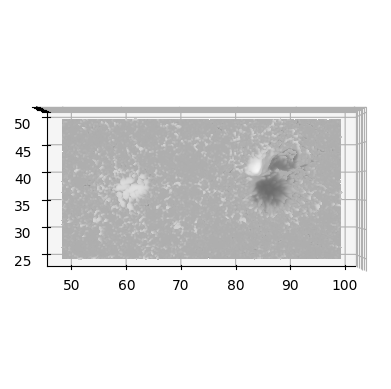

Bz z=0 Maximum 3227.2979
Bz z=0 Minimum -3081.8796


In [2]:
# data = read_issi_rmhd("data/RMHD_boundary_data.sav")
L = 1.0
cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    "", ["dimgray", "whitesmoke"]
)

data = read_issi_rmhd("/Users/lilli/Desktop/mflex/data/RMHD_boundary_data.sav", L)
# BFieldvec_Seehafer = np.load('field_data_potential.npy')

data_bx = data.data_x
data_by = data.data_y
data_bz = data.data_z
nresol_x = data.nresol_x
nresol_y = data.nresol_y
nresol_z = data.nresol_z
pixelsize_x = data.pixelsize_x
pixelsize_y = data.pixelsize_y
pixelsize_z = data.pixelsize_z
nf_max = data.nf_max
xmin = data.xmin
xmax = data.xmax
ymin = data.ymin
ymax = data.ymax
zmin = data.zmin
zmax = data.zmax
z0 = data.z0

deltaz = z0 / 10.0  # z0 at 2Mm so width of transition region = 200km
print("z0, deltaz", z0, deltaz)

x_arr = np.arange(2 * nresol_x) * (xmax - xmin) / (2 * nresol_x - 1) + xmin
y_arr = np.arange(2 * nresol_y) * (ymax - ymin) / (2 * nresol_y - 1) + ymin
z_arr = np.arange(nresol_z) * (zmax - zmin) / (nresol_z - 1) + zmin
x_grid, y_grid = np.meshgrid(x_arr, y_arr)
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.contourf(
    x_grid[nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x],
    y_grid[nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x],
    data_bz,
    1000,
    # offset=0.0,
    cmap=cmap,
)
ax.view_init(90, -90)
ax.set_box_aspect((xmax, ymax, zmax))
ax.set_zticklabels([])
plt.show()

print("Bz z=0 Maximum", data_bz.max())
print("Bz z=0 Minimum", data_bz.min())

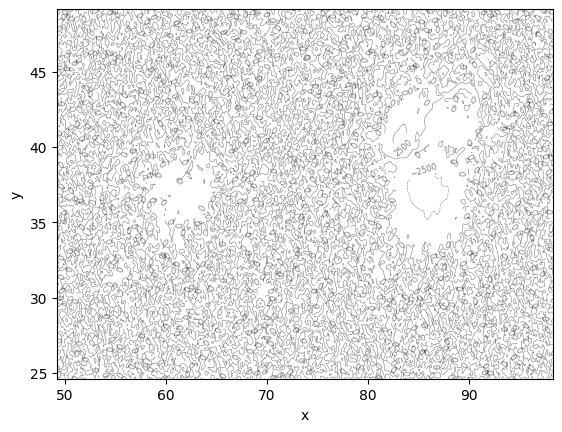

In [3]:
fig = plt.figure()
ax = fig.add_subplot(111)
CS = ax.contour(
    x_grid[nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x],
    y_grid[nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x],
    data_bz,
    2,
    colors="k",
    linewidths=0.4,
    alpha=0.5,
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.clabel(CS, fontsize=6, inline=True)
plt.show()

In [4]:
# z0_b = z0
# deltaz_b = deltaz
# a = 0.2
# alpha = 0.012
# b = 1.0

# length_scale = float(2.0 * L)  # Normalising length scale for Seehafer

# length_scale_x = 2.0 * nresol_x * pixelsize_x * L
# length_scale_y = 2.0 * nresol_y * pixelsize_y * L

# length_scale_x_norm = length_scale_x / length_scale
# length_scale_y_norm = length_scale_y / length_scale

# kx_arr = np.arange(nf_max) * np.pi / length_scale_x_norm  # [0:nf_max]
# ky_arr = np.arange(nf_max) * np.pi / length_scale_y_norm  # [0:nf_max]
# one_arr = 0.0 * np.arange(nf_max) + 1.0

# ky_grid = np.outer(ky_arr, one_arr)  # [0:nf_max, 0:nf_max]
# kx_grid = np.outer(one_arr, kx_arr)  # [0:nf_max, 0:nf_max]

# # kx^2 + ky^2

# k2_arr = np.outer(ky_arr**2, one_arr) + np.outer(one_arr, kx_arr**2)
# k2_arr[0, 0] = (np.pi / length_scale_x_norm) ** 2 + (
#     np.pi / length_scale_y_norm
# ) ** 2


# # Need k^2 > alpha^2/(1-2a) and k^2 > alpha^2

# limit = (k2_arr - (2*alpha)**2)/ (2*k2_arr)

# print(limit.min())

# bfield, dpartial_bfield = magnetic_field(
#     data_bz,
#     z0_b,
#     deltaz_b,
#     a,
#     b,
#     alpha,
#     xmin,
#     xmax,
#     ymin,
#     ymax,
#     zmin,
#     zmax,
#     nresol_x,
#     nresol_y,
#     nresol_z,
#     pixelsize_x,
#     pixelsize_y,
#     nf_max,
#     L,
# )

In [5]:
# save_field(bfield, dpartial_bfield, "issi_rmhd_" + str(a) + "_" + str(alpha) + "_" + str(b))

In [6]:
z0_b = z0
deltaz_b = deltaz
a = 0.01
alpha = 0.01
b = 1.0

bfield = np.load(
    "/Users/lilli/Desktop/mflex/results/issi_rmhd_" + str(a) + "_" + str(alpha) + "_" + str(b) + "_bfield3d.npy"
)
dpartial_bfield = np.load(
    "/Users/lilli/Desktop/mflex/results/issi_rmhd_" + str(a) + "_" + str(alpha) + "_" + str(b) + "_dbzdxdydz3d.npy"
)

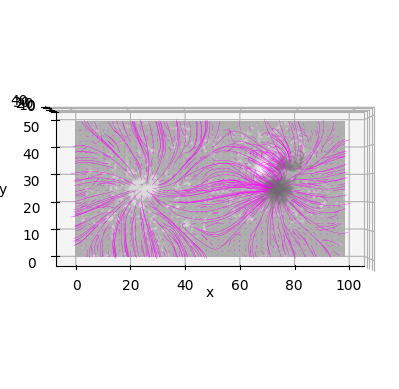

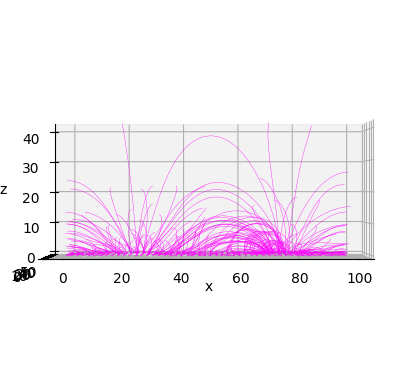

In [7]:
plot_top = plot_fieldlines_grid(
    bfield, L, -xmax, xmax, -ymax, ymax, zmin, zmax, stepsize=2.0, view="top", cmap=cmap
)

plotname = (
    "/Users/lilli/Desktop/mflex/seminar2024/rmhd_fieldlines_top_"
    + str(a)
    + "_"
    + str(alpha)
    + ".png"
)
plot_top.savefig(plotname, dpi=300)


plot_side = plot_fieldlines_grid(
    bfield,
    L,
    -xmax,
    xmax,
    -ymax,
    ymax,
    zmin,
    zmax,
    stepsize=2.0,
    view="side",
    cmap=cmap,
)

plotname = (
    "/Users/lilli/Desktop/mflex/seminar2024/rmhd_fieldlines_side_"
    + str(a)
    + "_"
    + str(alpha)
    + ".png"
)
plot_side.savefig(plotname, dpi=300)

In [8]:
temps = np.array((6000.0, 5500.0, 10000.0, 500000.0, 1000000.0, 1500000.0)) # Kelvin 
heights = np.array((0.0, 0.5, 2.0, 2.2, 5.0, 100.0)) # Mm

t_photosphere = temps[0]
t_corona = temps[-1]
t_z0 = temps[2]

g_solar = 272.2 # m/(s^2)
kB = 1.380649 * 10**-23  # Boltzmann constant in kg m^2/(Ks^2)
mbar = 1.67262 * 10**-27  # mean molecular weight (proton mass) in kg
h = (
    kB * t_z0 / (mbar * g_solar)
)  # in m 
rho0 = 2.7 * 10**-4  # plasma density at z = 0 in kg/m^3
b0 = 3227.2979 # Gauss background magnetic field strength in 10^-4 kg/(s^2A) = 10^-4 T
p0 = t_photosphere * kB * rho0 / mbar  # plasma pressure in kg/(s^2 m)
mu0 = 1.25663706 * 10**-6  # permeability of free space in mkg/(s^2A^2)
pB0 = (b0 * 10**-4)**2 / (2 * mu0)  # magnetic pressure b0**2 / 2mu0 in kg/(s^2 m)
beta0 = p0 / pB0  # Plasma Beta, ration plasma to magnetic pressure
h_photo = h / t_z0 * t_photosphere


print("Temperature Photosphere", t_photosphere)
print("Temperature Corona", t_corona)
print("g", g_solar)
print("mbar", mbar)
print("Pressure Scale height z0", h)
print("Pressure Scale height photosphere", h_photo)
print("Plasma Density Photosphere", rho0)
print("Magnetic field strength Photosphere", b0)
print("Plasma Pressure Photosphere", p0)
print("Magnetic Pressure Photosphere", pB0)
print("Plasma Beta", beta0)

Temperature Photosphere 6000.0
Temperature Corona 1500000.0
g 272.2
mbar 1.6726200000000002e-27
Pressure Scale height z0 303247.9518794428
Pressure Scale height photosphere 181948.77112766568
Plasma Density Photosphere 0.00027000000000000006
Magnetic field strength Photosphere 3227.2979
Plasma Pressure Photosphere 13372.142985256665
Magnetic Pressure Photosphere 41441.765752732186
Plasma Beta 0.3226730990432053


In [9]:
Backpres, Backden, dpres, dden, fpres_lin, fden_lin, backtemp = plasma_parameters_linear(
    z_arr,
    temps,
    heights,
    t_z0,
    t_photosphere,
    h,
    bfield,
    dpartial_bfield,
    z0_b,
    deltaz_b,
    a,
    b,
    mu0,
    g_solar,
    p0, 
    rho0
)

In [10]:
print("Pressure minimum lin", fpres_lin.min())
print("Pressure minimum lin", fpres_lin.argmin())
print("Density minimum lin", fden_lin.min())
print("Density minimum lin", fden_lin.argmin())

Pressure minimum lin -83938256901.82617
Pressure minimum lin 53810900
Density minimum lin -957163483.583469
Density minimum lin 84952400


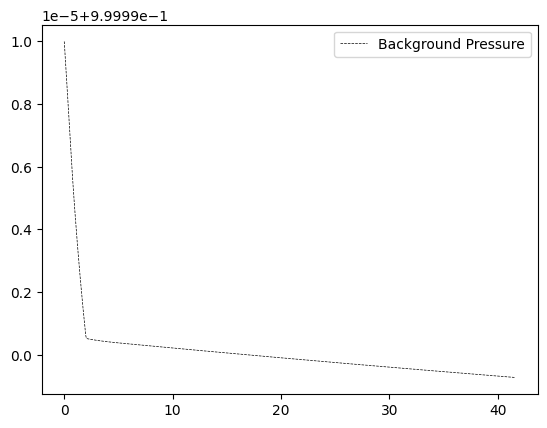

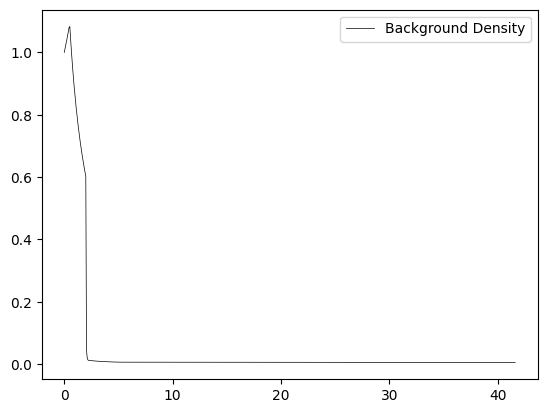

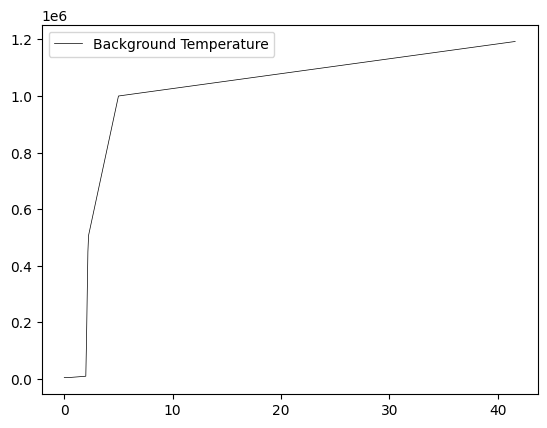

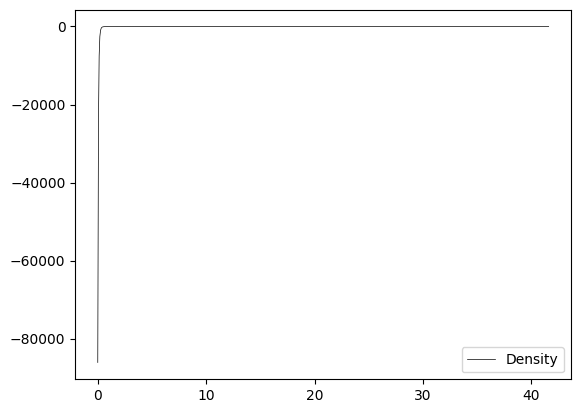

In [11]:
plt.plot(
    z_arr,
    Backpres[0,0,:],
    label=r"Background Pressure",
    linewidth=0.5,
    color="black",
    linestyle="dashed",
)
plt.legend()
plotname = "/Users/lilli/Desktop/mflex/seminar2024/ISSI_rmhd_back_at.png"
plt.savefig(plotname, dpi=300)
plt.show()

plt.plot(
    z_arr,
    Backden[0,0,:],
    label=r"Background Density",
    linewidth=0.5,
    color="black",
    linestyle="solid",
)
plt.legend()
plotname = "/Users/lilli/Desktop/mflex/seminar2024/ISSI_rmhd_back_at.png"
plt.savefig(plotname, dpi=300)
plt.show()

plt.plot(
    z_arr,
    backtemp,
    label=r"Background Temperature",
    linewidth=0.5,
    color="black",
    linestyle="solid",
)
plt.legend()
plotname = "/Users/lilli/Desktop/mflex/seminar2024/ISSI_rmhd_back_temp.png"
plt.savefig(plotname, dpi=300)
plt.show()

plt.plot(
    z_arr,
    fden_lin[0,0,:],
    label=r"Density",
    linewidth=0.5,
    color="black",
    linestyle="solid",
)
plt.legend()
plt.show()

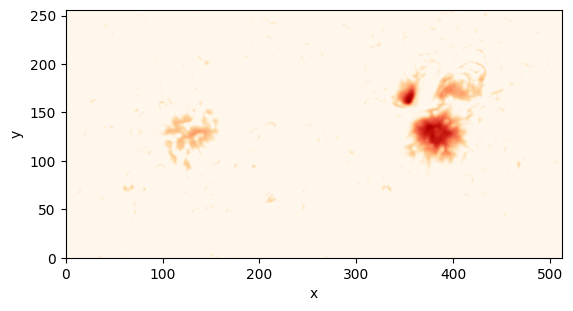

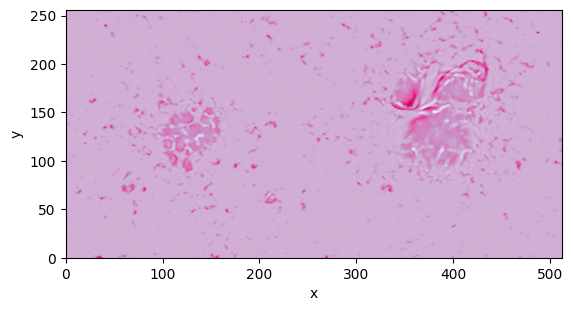

In [12]:
x_arr = np.arange(nresol_x) * (nresol_x) / (nresol_x - 1)
y_arr = np.arange(nresol_y) * (nresol_y) / (nresol_y - 1)
x_plot = np.outer(y_arr, np.ones(nresol_x))
y_plot = np.outer(x_arr, np.ones(nresol_y)).T

fig = plt.figure()
ax = fig.add_subplot(111)
ax.contourf(y_plot, x_plot, fpres_lin[:, :, 0], 1000, cmap="OrRd_r")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_aspect(1)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.contourf(y_plot, x_plot, fden_lin[:, :, 0], 1000, cmap="PuRd_r")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_aspect(1)
plt.show()

In [13]:
path3d = "/Users/lilli/Desktop/mflex/data/RMHD_3D_data.sav"
data3d = scipy.io.readsav(path3d, python_dict=True, verbose=True)

print(data3d["info_array"])

data_bx = data3d["b3dx"]
data_by = data3d["b3dy"]
data_bz = data3d["b3dz"]

pres_3d = data3d["p3d"]
den_3d = data3d["d3d"]

--------------------------------------------------
Date: Tue Sep  6 15:19:40 2022
User: xszhu
Host: HR30
--------------------------------------------------
Format: 9
Architecture: x86_64
Operating System: linux
IDL Version: 7.1.1
--------------------------------------------------
Successfully read 12 records of which:
 - 1 are of type NOTICE
 - 8 are of type VARIABLE
 - 1 are of type VERSION
 - 1 are of type TIMESTAMP
--------------------------------------------------
Available variables:
 - b3dx [<class 'numpy.ndarray'>]
 - b3dy [<class 'numpy.ndarray'>]
 - b3dz [<class 'numpy.ndarray'>]
 - d3d [<class 'numpy.ndarray'>]
 - p3d [<class 'numpy.ndarray'>]
 - info_unit [<class 'bytes'>]
 - info_pixel [<class 'bytes'>]
 - info_array [<class 'bytes'>]
--------------------------------------------------
b'Array example: d3d(nx,ny,nz)'


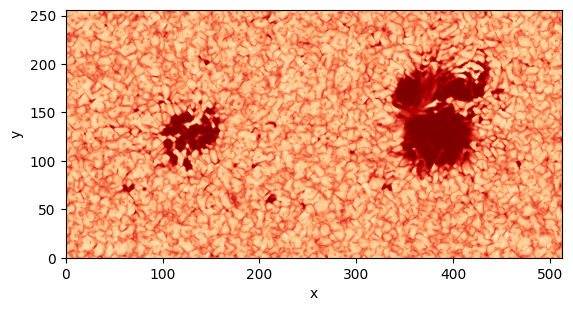

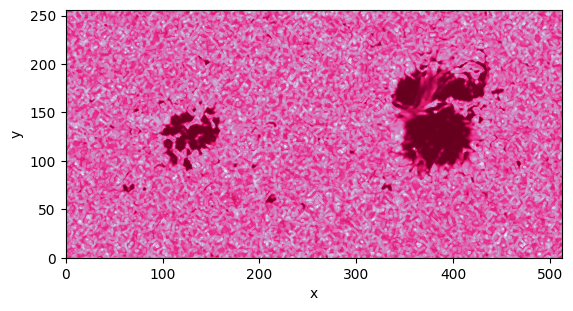

Pressure minimum issi 0.011467607
Pressure minimum issi 8348393
Density minimum issi 1.944082e-19
Density minimum issi 7518648


In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.contourf(y_plot, x_plot, pres_3d[0, :, :], 1000, cmap="OrRd_r")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_aspect(1)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.contourf(y_plot, x_plot, den_3d[0, :, :], 1000, cmap="PuRd_r")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_aspect(1)
plt.show()

print("Pressure minimum issi", pres_3d.min())
print("Pressure minimum issi", pres_3d.argmin())
print("Density minimum issi", den_3d.min())
print("Density minimum issi", den_3d.argmin())

In [15]:
print(data_bx.shape)
print(data_by.shape)
print(data_bz.shape)

bfield_bx = bfield[nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x, :, 1]
bfield_by = bfield[nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x, :, 0]
bfield_bz = bfield[nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x, :, 2]
print(bfield_bx.shape)
print(bfield_by.shape)
print(bfield_bz.shape)

issi_bx = 0.0 * bfield_bx
issi_by = 0.0 * bfield_by
issi_bz = 0.0 * bfield_bz

for i in range(0, nresol_y):
    for j in range(0, nresol_x):
        for k in range(0, 650):
            issi_bx[i, j, k] = data_bx[k, i, j]
            issi_by[i, j, k] = data_by[k, i, j]
            issi_bz[i, j, k] = data_bz[k, i, j]

B_rec = np.array((bfield_by, bfield_bx, bfield_bz))
B_ref = np.array((issi_by, issi_bx, issi_bz))

print("Vec Corr", vec_corr_metric(B_ref, B_rec))
print("Ref", vec_corr_metric(B_ref, B_ref))
print("Cau Schw", cau_Schw_metric(B_ref, B_rec))
print("Ref", cau_Schw_metric(B_ref, B_ref))
print("Norm err", norm_vec_err_metric(B_ref, B_rec))
print("Ref", norm_vec_err_metric(B_ref, B_ref))
print("Mean err", mean_vec_err_metric(B_ref, B_rec))
print("Ref", mean_vec_err_metric(B_ref, B_ref))
print("Mag ener", mag_ener_metric(B_ref, B_rec))
print("Ref", mag_ener_metric(B_ref, B_ref))

(652, 256, 512)
(652, 256, 512)
(652, 256, 512)
(256, 512, 650)
(256, 512, 650)
(256, 512, 650)
Vec Corr 0.8856878602671144
Ref 1.0
Cau Schw 0.6463321157602163
Ref 1.0
Norm err 0.48431085157321385
Ref 0.0
Mean err 6.881197004399299
Ref 0.0
Mag ener 2.205504586635383
Ref 1.0


In [16]:
B_ref_See = 0.0 * bfield
print(B_ref_See.shape)
print(B_ref.shape)

for iz in range(0, nresol_z - 2):
    for ix in range(0, nresol_x):
        for iy in range(0, nresol_y):
            for id in range(0, 3):
                B_ref_See[nresol_y + iy, nresol_x + ix, iz, id] = B_ref[id, iy, ix, iz]
                B_ref_See[nresol_y + iy, ix, iz, id] = -B_ref[
                    id, iy, nresol_x - 1 - ix, iz
                ]
                B_ref_See[iy, nresol_x + ix, iz, id] = -B_ref[
                    id, nresol_y - 1 - iy, ix, iz
                ]
                B_ref_See[iy, ix, iz, id] = B_ref[
                    id, nresol_y - 1 - iy, nresol_x - 1 - ix, iz
                ]

(512, 1024, 650, 3)
(3, 256, 512, 650)


In [ ]:
plot_fieldlines_grid(
    B_ref_See,
    L,
    -xmax,
    xmax,
    -ymax,
    ymax,
    zmin,
    zmax,
    stepsize=2.0,
    view="top",
    cmap=cmap
)

plot_fieldlines_grid(
    B_ref_See,
    L,
    -xmax,
    xmax,
    -ymax,
    ymax,
    zmin,
    zmax,
    stepsize=2.0,
    view="side",
    cmap=cmap
)

In [ ]:
hmin = 0.0
hmax = L
h1 = L/100.0
eps = 1.0 * 10**-8

print(
    "Field line",
    field_div_metric(
        B_ref_See,
        bfield,
        h1,
        hmin,
        hmax,
        eps,
        nresol_x,
        nresol_y,
        nresol_z,
        -xmax,
        xmax,
        -ymax,
        ymax,
        zmin,
        zmax,
        stepsize=2.0,
    ),
)
print(
    "Ref",
    field_div_metric(
        B_ref_See,
        B_ref_See,
        h1,
        hmin,
        hmax,
        eps,
        nresol_x,
        nresol_y,
        nresol_z,
        -xmax,
        xmax,
        -ymax,
        ymax,
        zmin,
        zmax,
        stepsize=2.0,
    ),
)

In [ ]:
pres_surface_ref, den_surface_ref, pres_surface_rec, den_surface_rec = (
    pearson_corr_coeff(
        pres_3d[0:650, :, :],
        den_3d[0:650, :, :],
        fpres_lin,
        fden_lin,
        nresol_x,
        nresol_y,
        nresol_z,
        zmin,
        zmax,
    )
)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.contourf(y_plot, x_plot, pres_surface_ref, 1000, cmap="bone")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.contourf(y_plot, x_plot, den_surface_ref, 1000, cmap="bone")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.contourf(y_plot, x_plot, pres_surface_rec, 1000, cmap="bone")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.contourf(y_plot, x_plot, den_surface_rec, 1000, cmap="bone")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()